<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/2.0-data-preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

_taken from [narrative seminar Osteoarthritis by Hunter & Bierma-Zeinstra (2019) in the Lancet](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf)._

Outcomes from total joint replacement can be optimised if patient selection identifies marked joint space narrowing. Most improvement will be made in patients with complete joint space loss and evident bone attrition. Up to 25% of patients presenting for total joint replacement continue to complain of pain and disability 1 year after well performed surgery. Careful preoperative patient selection (including consideration of the poor outcomes that are more common in people who are depressed, have minimal radiographic disease, have minimal pain, and who are morbidly obese), shared decision making about surgery, and informing patients about realistic outcomes of surgery are needed to minimise the likelihood of dissatisfaction.

# Data Preparation

This is day 2 from the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/outline.md).



## Learning objectives: select and clean data
- Impute missing values
- Select main input variables X (feature engineering)
- Define target Y (clustered classes, categories)
- Decide how to handle correlated input features

## Learning objectives: Python

- [Pythonic data cleaning](https://realpython.com/python-data-cleaning-numpy-pandas/)
- [When to use list comprehensions](https://realpython.com/list-comprehension-python/)
- [Python f-strings](https://realpython.com/python-f-strings/)
- [Using sets](https://realpython.com/python-sets/)
- [pandas GroupBy](https://realpython.com/pandas-groupby/)
- [Correlations in with numpy, scipy and pandas](https://realpython.com/numpy-scipy-pandas-correlation-python/)
- [Linear Regression in Python](https://realpython.com/linear-regression-in-python/)
- Extra: [Using itertools](https://realpython.com/python-itertools/#what-is-itertools-and-why-should-you-use-it)

## Recap from previous lecture
- Good outcome for knee replacement Y is measured using difference in Oxford Knee Score (OKS)
- Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.
- to account for the ceiling effect, a high final `t1_oks_score` is also considered as a good outcome (even if `delta_oks_score` is smaller than 14).

    

# Cleaning data


In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model

#supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

## Intermezzo: Python skills



### Using list comprehensions

There are three ways to work with lists in Python:
1. with `for` loops
2. using `map` (map-reduce pattern)
3. using list comprehensions

The third option finds its roots in functional programming and is considered the most Pythonic. It is particularly useful for data science.

In this case, we want to make group of columns by name, without having to continously re-type the names. We will use some functions from the [itertools](https://docs.python.org/3.7/library/itertools.html#module-itertools) standard library.

**Excercise:** find all columns that contain the value 9.
Using [`pd.Series.any()`]\(https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.any.html), create a list of all columns that contain the value 9. (Answer is given later in this notebook).

In [2]:
from itertools import product

# a product generates a carterian product
['_'.join(col) for col in product(['t0', 't1'],  ['assisted', 'previous_surgery', 'disability'])]

['t0_assisted',
 't0_previous_surgery',
 't0_disability',
 't1_assisted',
 't1_previous_surgery',
 't1_disability']

In [3]:
# helper function to count top 10 unique values for dataframe
# pd.concat takes as list of Series or DataFrames to concatenate
# make this list using a list comprehension
def count_values(df):
  _value_counts = [df[col].value_counts().sort_values(ascending=False).head(10) for col in df.columns]
  return pd.concat(_value_counts, axis=1).transpose()

### Using f-strings

In [4]:
def oks_questions(t='t0'):
  return [f'oks_{t}_pain', f'oks_{t}_night_pain', f'oks_{t}_washing',
          f'oks_{t}_transport', f'oks_{t}_walking', f'oks_{t}_standing',
          f'oks_{t}_limping', f'oks_{t}_kneeling', f'oks_{t}_work',
          f'oks_{t}_confidence', f'oks_{t}_shopping', f'oks_{t}_stairs', ]

def eq5d_questions(t='t0'):
  return [f'{t}_mobility', f'{t}_self_care',
          f'{t}_activity', f'{t}_discomfort', f'{t}_anxiety']

oks_questions('t1')

['oks_t1_pain',
 'oks_t1_night_pain',
 'oks_t1_washing',
 'oks_t1_transport',
 'oks_t1_walking',
 'oks_t1_standing',
 'oks_t1_limping',
 'oks_t1_kneeling',
 'oks_t1_work',
 'oks_t1_confidence',
 'oks_t1_shopping',
 'oks_t1_stairs']

## Inspect boolean features (T0)

In [5]:
comorb = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes',
           'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
boolean = ['t0_assisted', 't0_previous_surgery', 't0_disability']
count_values(df[['gender'] + comorb + boolean])

,1.0,2.0,9.0
gender,55749.0,74085.0,NaN
heart_disease,13051.0,NaN,126185.0
high_bp,61570.0,NaN,77666.0
stroke,2303.0,NaN,136933.0
circulation,7882.0,NaN,131354.0
lung_disease,12779.0,NaN,126457.0
diabetes,17379.0,NaN,121857.0
kidney_disease,2856.0,NaN,136380.0
nervous_system,1422.0,NaN,137814.0
liver_disease,812.0,NaN,138424.0


## Inspect categorical features (T0)


In [6]:
eq5d = ['t0_mobility', 't0_self_care', 't0_activity', 't0_discomfort', 't0_anxiety']
categorical = ['t0_symptom_period', 't0_previous_surgery', 't0_living_arrangements']

# useless variables
useless = ['t0_assisted_by', 't0_eq5d_index', 't0_eq5d_index_profile']

count_values(df[eq5d + categorical])

,1,2,3,4,9
t0_mobility,10799.0,123763.0,388.0,NaN,4286.0
t0_self_care,93976.0,39843.0,1007.0,NaN,4410.0
t0_activity,12648.0,105171.0,16928.0,NaN,4489.0
t0_discomfort,1408.0,80643.0,51645.0,NaN,5540.0
t0_anxiety,85417.0,43307.0,5351.0,NaN,5161.0
t0_symptom_period,6488.0,71767.0,30434.0,29338.0,1209.0
t0_previous_surgery,10784.0,127410.0,NaN,NaN,1042.0
t0_living_arrangements,106041.0,30489.0,133.0,486.0,2087.0


## Impute missing values

* No missing values: gender, age_band and all comorbidity variables
* Booleans with missing values: most frequent
* Categorical:
  * eq5d: use most frequent
  * symptom_period, living arrangements: use most frequent
* Numerical: impute EQ-VAS with median

Since we are going to replace values, we choose to convert the data to the most optimal type.

Write code in such a way that you can easily adopt this strategy.

In [7]:
# list of columns which contain 9s
cols_with_9 = [col for col in df.columns if (df[col]==9).any()]

# columns where 9 is *not* a sentinel value
cols_keep_9 = comorb + [ 't0_eq_vas', 't1_eq_vas','oks_t0_score', 'oks_t1_score']

# columns with 9 as sentinel value
cols_sentinel_9 = list(set(cols_with_9) ^ set(cols_keep_9))
count_values(df[cols_sentinel_9]).sort_index()

,0,1,2,3,4,5,6,9
oks_t0_confidence,18877.0,40686.0,32501.0,35050.0,10780.0,NaN,NaN,1342.0
oks_t0_kneeling,60103.0,48650.0,24326.0,4022.0,739.0,NaN,NaN,1396.0
oks_t0_limping,60433.0,47425.0,16080.0,12158.0,1725.0,NaN,NaN,1415.0
oks_t0_night_pain,45021.0,40943.0,35851.0,7380.0,8737.0,NaN,NaN,1304.0
oks_t0_pain,70493.0,60701.0,6171.0,1340.0,333.0,NaN,NaN,198.0
oks_t0_shopping,24162.0,27235.0,46012.0,26975.0,13509.0,NaN,NaN,1343.0
oks_t0_stairs,7612.0,46072.0,58010.0,21349.0,4855.0,NaN,NaN,1338.0
oks_t0_standing,4765.0,59989.0,50796.0,19684.0,2549.0,NaN,NaN,1453.0
oks_t0_transport,740.0,31896.0,72115.0,23997.0,9138.0,NaN,NaN,1350.0
oks_t0_walking,17037.0,17499.0,56402.0,35763.0,11092.0,NaN,NaN,1443.0


In [8]:
from sklearn.impute import SimpleImputer

impute_median = SimpleImputer(strategy='median')
impute_most_frequent = SimpleImputer(strategy='most_frequent')

# use copy of original data
dfc = df.copy()

# replace 9 with np.nan and impute most frequent
dfc.loc[:,cols_sentinel_9] = df.loc[:,cols_sentinel_9].replace(9, np.nan)
impute_most_frequent.fit(dfc[cols_sentinel_9])
pd.DataFrame({'columns': cols_sentinel_9, 'most_frequent': impute_most_frequent.statistics_}).head(10)

,columns,most_frequent
0,t1_anxiety,1.0
1,t0_mobility,2.0
2,t1_wound,2.0
3,oks_t1_pain,3.0
4,t1_sucess,1.0
5,oks_t0_washing,4.0
6,oks_t1_standing,3.0
7,oks_t1_washing,4.0
8,t0_disability,1.0
9,oks_t1_kneeling,0.0


In [9]:
# assign imputed data
dfc.loc[:, cols_sentinel_9] = impute_most_frequent.transform(dfc[cols_sentinel_9])

In [10]:
# same procedure for 999 sentinel values, using impute median
eq_vas = ['t0_eq_vas', 't1_eq_vas']
dfc.loc[:, eq_vas] = dfc.loc[:,eq_vas].replace(999, np.nan)
impute_median.fit(dfc.loc[:,eq_vas])
dfc.loc[:,eq_vas] = impute_median.transform(dfc.loc[:,eq_vas])
impute_median.statistics_

array([70., 80.])

## Format data

In [11]:
# transform into boolean
dfc['female'] = dfc.loc[:,'gender'].replace({1: False, 2: True})
dfc.loc[:, comorb] = dfc.loc[:, comorb].replace({9: False, 1: True})
dfc.loc[:, boolean] = dfc.loc[:, boolean].replace({1: True, 2: False})

In [12]:
# helper function for counting boolean attribues
def count_boolean(series):
    '''
    Returns absolute and normalized value counts of pd.series as a dataframe with 
    index = series.name
    columns with absolute and normalized counts of each value
    '''
    try:
        count = series.value_counts().to_frame().transpose()
        norm = series.value_counts(normalize=True).to_frame().transpose()
        return count.join(norm, lsuffix='_count', rsuffix='_normalized') 
    except:
        print('Error: expecting a pandas.Series object as input. \n' + count_boolean.__doc__)
        return None

pd.concat([count_boolean(dfc[col]) for col in ['female'] + comorb + boolean]).round(2)

,True_count,False_count,True_normalized,False_normalized
female,74085,55749,0.57,0.43
heart_disease,13051,126185,0.09,0.91
high_bp,61570,77666,0.44,0.56
stroke,2303,136933,0.02,0.98
circulation,7882,131354,0.06,0.94
lung_disease,12779,126457,0.09,0.91
diabetes,17379,121857,0.12,0.88
kidney_disease,2856,136380,0.02,0.98
nervous_system,1422,137814,0.01,0.99
liver_disease,812,138424,0.01,0.99


In [13]:
# convert to categories
dfc.loc[:, ['provider_code', 'age_band']] = dfc.loc[:, ['provider_code', 'age_band']].astype('category')

## Selecting input features X

In [14]:
# input features
# TO DO: decide what to do with years?!

# feature engineering
for t in ("t0", "t1"):
    dfc[f"oks_{t}_pain_total"] = dfc[f"oks_{t}_pain"] + dfc[f"oks_{t}_night_pain"]
    dfc[f"oks_{t}_functioning_total"] = (
        dfc.loc[:, [col for col in oks_questions(t) if "pain" not in col]]
        .sum(axis=1)
    )
dfc["n_comorb"] = dfc.loc[:, comorb].sum()

X_features = (
    ["provider_code", "female", "age_band"]
    + comorb
    + boolean
    + eq5d_questions("t0")
    + oks_questions("t0")
    + ["t0_eq_vas", "oks_t0_pain_total", "n_comorb"]
)
X_features

['provider_code',
 'female',
 'age_band',
 'heart_disease',
 'high_bp',
 'stroke',
 'circulation',
 'lung_disease',
 'diabetes',
 'kidney_disease',
 'nervous_system',
 'liver_disease',
 'cancer',
 'depression',
 'arthritis',
 't0_assisted',
 't0_previous_surgery',
 't0_disability',
 't0_mobility',
 't0_self_care',
 't0_activity',
 't0_discomfort',
 't0_anxiety',
 'oks_t0_pain',
 'oks_t0_night_pain',
 'oks_t0_washing',
 'oks_t0_transport',
 'oks_t0_walking',
 'oks_t0_standing',
 'oks_t0_limping',
 'oks_t0_kneeling',
 'oks_t0_work',
 'oks_t0_confidence',
 'oks_t0_shopping',
 'oks_t0_stairs',
 't0_eq_vas',
 'oks_t0_pain_total',
 'n_comorb']

## Selecting outcome Y

Figure 4 from the [narrative on outcomes of osteoarthritis](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf) states that the [European League Against Rheumatism (EULAR)](https://eular.org) standard considers three primary symptoms, namely:
- Hip/knee pain
- Early morning stiffness (EMS)
- Functional limitations

Comparing these with the [ICHOM standard set for hip & knee osteoarthritis](https://www.ichom.org/portfolio/hip-knee-osteoarthritis/) we take pain and functional limitations as the primairy outcome parameters as ICHOM does not include EMS as a relevant outcome parameter. We now turn to the NHS dataset to choose which (engineered) features are available as a measure for pain and physical functioning at `t1`.

![](https://ichom.org/wp-content/uploads/2018/06/ichom_outcome_oa_3.jpg)

### Pain

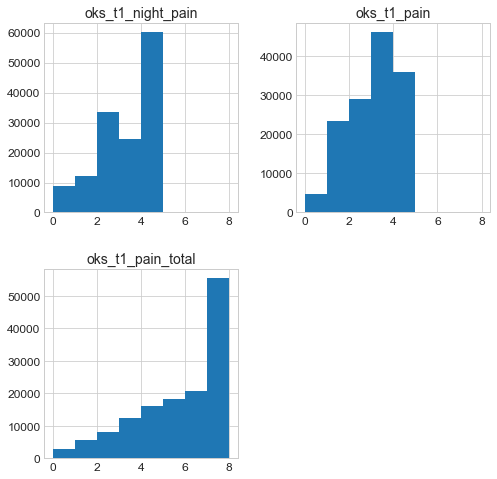

In [15]:
dfc[['oks_t1_pain', 'oks_t1_night_pain', 'oks_t1_pain_total']].hist(bins=range(0,9), figsize=S);

### Physical functioning

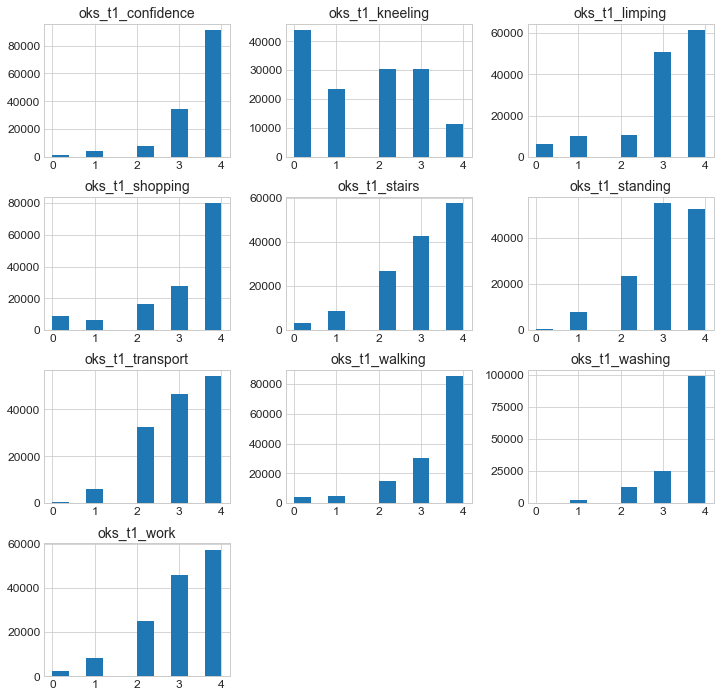

In [16]:
dfc.loc[:, [col for col in oks_questions("t1") if "pain" not in col],].hist(figsize=M);

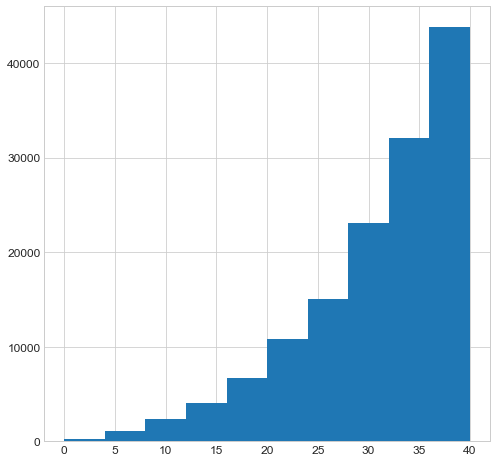

In [17]:
dfc['oks_t1_functioning_total'].hist(figsize=S);

### Combined outcome Y

One of the challenges in quantifying outcomes is to find a relevant measure to detect meaningful clinical change. This is well-known subject in e.g.
[development of psychometic tests](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/wise2004methods.pdf). More heuristically, one can think of [analyzing the intersection between the histograms](http://blog.datadive.net/histogram-intersection-for-change-detection/), in this case measured at `t0` and `t1`.

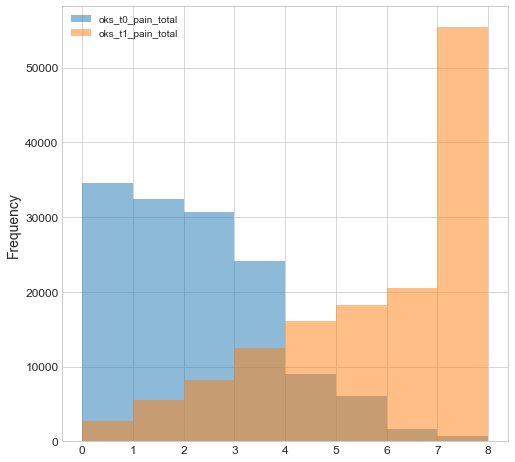

In [18]:
dfc[['oks_t0_pain_total', 'oks_t1_pain_total']].plot.hist(bins=range(0,9), alpha=0.5, figsize=S);

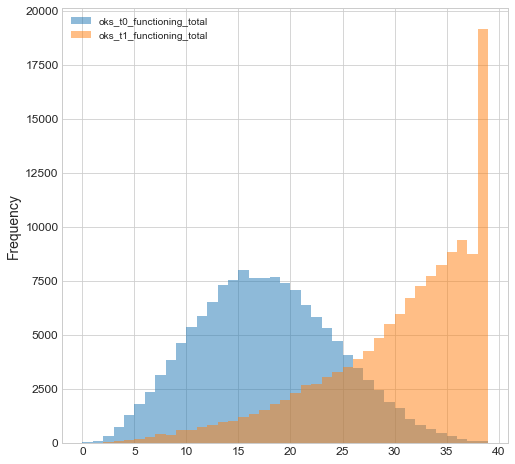

In [19]:
dfc[['oks_t0_functioning_total', 'oks_t1_functioning_total']].plot.hist(bins=range(0,40), alpha=0.5, figsize=S);

One way to combine pain and functioning into one outcome parameter is to define the cut-off points:
- `oks_pain_total >= 4`: good outcome with less pain
- `oks_functioning_total >= 26`: good outcome with improved functioning

Visualize this using jointplots, and one can image that at `t0` the majority of patients are in the bottom-left quadrant (much pain, poor functioning). Subsequently, at `t1` most patient are in the top-right quadrant with less pain and improved functioning.

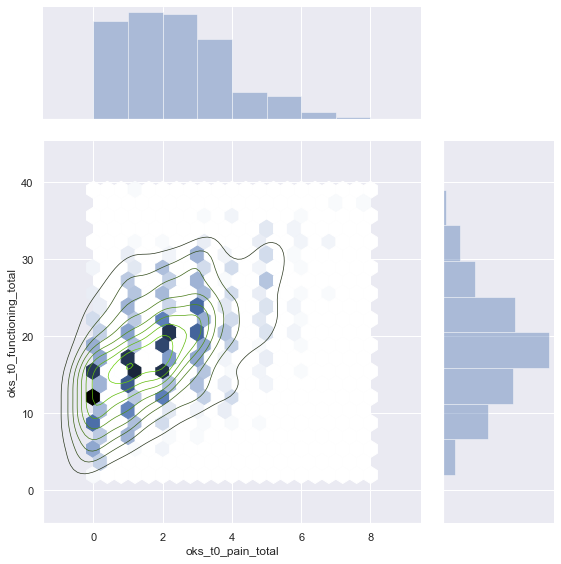

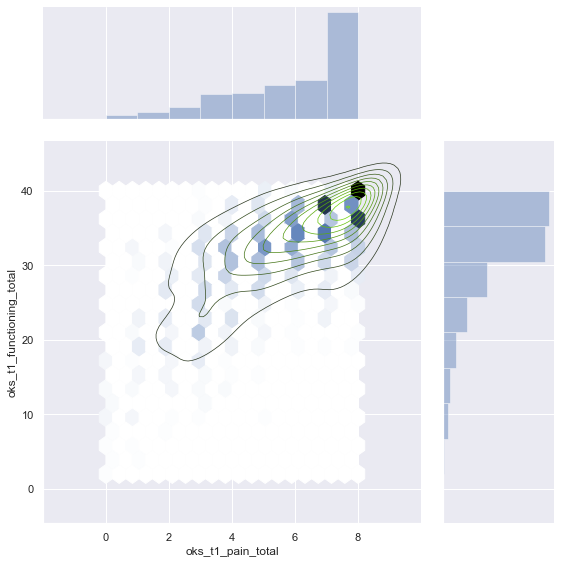

In [20]:
BINS = 8
SAMPLE = 1000

# https://stackoverflow.com/questions/45540886/reduce-line-width-of-seaborn-timeseries-plot
sns.set(rc={"lines.linewidth": 0.7})
fig1_layout = {
    'kind': "hex",
    'height': 8,
    'ratio': 3,
    'stat_func': None, 
    'marginal_kws': {'bins': BINS, 'rug': False},
}
j1 = (sns.jointplot(
            'oks_t0_pain_total', 'oks_t0_functioning_total',
            data=dfc[['oks_t0_pain_total', 'oks_t0_functioning_total']].head(SAMPLE),
            **fig1_layout)
         .plot_joint(sns.kdeplot, color='lawngreen'))
j2 = (sns.jointplot(
            'oks_t1_pain_total', 'oks_t1_functioning_total',
            data=dfc[['oks_t1_pain_total', 'oks_t1_functioning_total']].head(SAMPLE), 
            **fig1_layout)
         .plot_joint(sns.kdeplot, color='lawngreen' ));

So let's add boolean columns indicating whether pain is 'good' (i.e. no pain) and functioning is good, both at `t0` and `t1`.

In [21]:
# add boolean columns
for t in ('t0', 't1'):
    dfc[f'y_{t}_pain_good'] = dfc[f'oks_{t}_pain_total'].apply(lambda s: True if s >= 4 else False)
    dfc[f'y_{t}_functioning_good'] = dfc[f'oks_{t}_functioning_total'].apply(lambda s: True if s >= 26 else False)

In [22]:
# inspect whether new features are correct
dfc[[col for col in dfc.columns if '_good' in col]].head(10)

,y_t0_pain_good,y_t0_functioning_good,y_t1_pain_good,y_t1_functioning_good
0,False,False,True,True
1,True,True,True,True
2,True,True,True,True
3,False,False,True,True
4,False,False,True,False
5,False,True,False,True
6,False,True,True,True
7,False,False,True,True
8,False,False,True,False
9,False,True,True,True


In [23]:
pd.crosstab(dfc.y_t0_pain_good, dfc.y_t0_functioning_good, normalize=True)

y_t0_functioning_good,False,True
y_t0_pain_good,,
False,0.81,0.07
True,0.08,0.05


In [24]:
pd.crosstab(dfc.y_t1_pain_good, dfc.y_t1_functioning_good, normalize=True)

y_t1_functioning_good,False,True
y_t1_pain_good,,
False,0.15,0.06
True,0.08,0.71


### Alternative outcome parameter: combine absolute value with MCID

In [25]:
# add delta_oks_score and Y
def good_outcome(oks_t1, delta_oks, abs_threshold=43, mcid=13):
  if oks_t1 > abs_threshold or delta_oks > mcid:
    return True
  else:
    return False

dfc['delta_oks_score'] = dfc.oks_t1_score - dfc.oks_t0_score
dfc['Y'] = dfc.apply(lambda row: good_outcome(row['oks_t1_score'], row['delta_oks_score']), axis=1)
dfc.Y.value_counts(normalize=True)

True     0.66
False    0.34
Name: Y, dtype: float64

# Getting into scikit-learn: regression

## Simple linear regression
To illustrate linear regression, we use `t1_eq_vas` as numeric outcome. First we will assess whether there is a correlation between `t0` and `t1` values of `eq_vas`

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


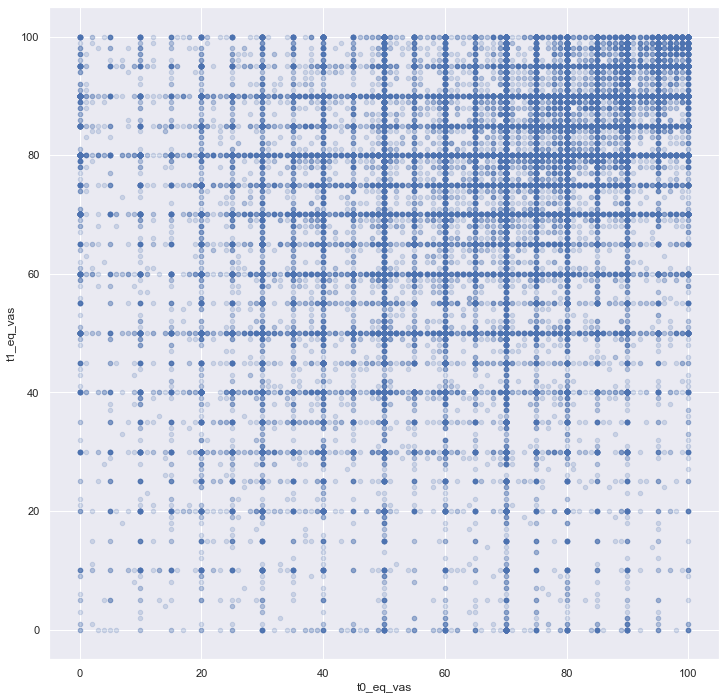

In [26]:
dfc.plot(kind='scatter', x='t0_eq_vas', y='t1_eq_vas', figsize=M, alpha=0.2);

In [27]:
from sklearn.linear_model import LinearRegression

# x needs to be a column vector or an matrix
x = dfc.t0_eq_vas.values.reshape(-1, 1)

# y is a row vector
y = dfc.t1_eq_vas.values
print(f'x: {x[:5]}\n y: {y[:5]}')

x: [[80.]
 [70.]
 [70.]
 [70.]
 [75.]]
 y: [80. 95. 98. 60. 80.]


In [28]:
# linear regression with t0_eq_vas
lr = LinearRegression().fit(x, y)
r2 = lr.score(x, y)
print(f'r2: {r2:.2f}')

r2: 0.12


## Regression with decision trees
Next, let's try more parameters to perform regression on `t1_eq_vas`.

In [29]:
from sklearn.tree import DecisionTreeRegressor

# regression can only take numeric input features
X = dfc.loc[:, X_features].select_dtypes(include='float64').drop(columns=['n_comorb'])
y = dfc.t1_eq_vas.values
dtr = DecisionTreeRegressor().fit(X,y)
dt_r2 = dtr.score(X, y)
print(f'DecisionTreeRegressor r2: {dt_r2:.2f}')

DecisionTreeRegressor r2: 0.97


In [30]:
# this doesn't make sense, probably overfitting
dtr = DecisionTreeRegressor(max_depth=5).fit(X,y)
dt_r2 = dtr.score(X, y)
print(f'DecisionTreeRegressor r2: {dt_r2:.2f}')

DecisionTreeRegressor r2: 0.18


# Conclusion and reflection

## Discussion of results

* What outcome parameter would you use?
* What features would you include in your first iteration

## Checklist for results from data preparation process
* Input regarding the moment of prediction
* Input for data cleaning (handling missing data; removing variables not known at time of prediction, near-zero variance variables, etc)
* Input for feature engineering (adjusting variables based on tree-analyses, based on correlations, based on domain-analysis)
* Input for defining the outcome variable Y
* Input for defining the business objective in terms of generalizability (in case of missing Y values)
* Input for choosing the business objective in case there are still multiple options at the table
* Input for defining the scope of the business objective (e.g. limiting to a subgroup to get a better balanced outcome variable)
* A potential revision of the goal of your business objective
* Input for which variables and combination of variables seem particularly relevant within the to-be-developed algorithms 